In [71]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
import re
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import export_text

In [72]:
# Load JSON file
df = pd.read_json('data.json', encoding = 'utf-8')
# Display the DataFrame
df.head()

,Customer_ID,Age,Gender,Income_Level,Address,Transaction_ID,Purchase_Date,Product_ID,Product_Category,Brand,Purchase_Amount,Average_Spending_Per_Purchase,Purchase_Frequency_Per_Month,Brand_Affinity_Score,Product_Category_Preferences,Month,Year,Season,Will_Purchase_Next_Month
0,b81ee6c9-2ae4-48a7-b283-220eaa244f43,40,Female,Medium,"43548 Murray Islands Suite 974\nAmyberg, CT 13457",c6a6c712-e36b-406a-bfde-f53bdcf4744f,2022-04-26,d2f767d6-b01a-41a2-87f7-ec1d1186f50e,Clothing,Brand_C,193,59,2,2,Low,01,2010,Winter,1
1,,25,Male,High,,0b587838-1e4f-4231-b488-42bcd47c052a,2021-08-10,79eadc55-2de1-41cf-b1b6-40118c0bf8ec,Books,Brand_A,318,77,2,1,Low,08,1989,Fall,1
2,fdf79bcd-5908-4c90-8501-570ffb5b7648,57,Other,Low,"79683 Kevin Hill Apt. 555\nJohnshire, AR 39961",462925b1-a5bf-4996-bda2-59749de64eea,2021-12-09,9ab75a68-4329-4bd9-a259-2233c0f34c93,Electronics,Brand_A,197,100,9,1,Low,,1995,Winter,1
3,878dccba-893a-48f9-8d34-6ed394fa3c9c,38,Female,Medium,02998 Hall Meadows Suite 809\nNorth Robertvill...,3cfafa02-6b34-4d77-9e05-d223dfab64e8,2022-12-03,d518569b-ff79-494b-b2b6-7e2af39db86a,Clothing,Brand_C,262,97,3,4,Low,09,2012,Fall,1
4,0af0bd81-73cc-494e-aa5e-75c6d0b6d743,68,Other,Medium,"21411 Timothy Ford Apt. 320\nDavisborough, AR ...",0d8dc27a-0c8f-4a82-b57e-8bf54cee9759,2020-06-08,b6deac9d-2b7e-4a51-8273-a6534910b3bc,Books,Brand_B,429,85,7,2,High,01,2010,Summer,1


**Preprocess the dataset**

In [73]:
df= df[df['Product_Category'] == 'Electronics']
print(df['Product_Category'])

2      Electronics
15     Electronics
16     Electronics
17     Electronics
20     Electronics
          ...     
988    Electronics
990    Electronics
991    Electronics
993    Electronics
995    Electronics
Name: Product_Category, Length: 355, dtype: object


In [ ]:
print(df.dtypes)

Customer_ID                      object
Age                              object
Gender                           object
Income_Level                     object
Address                          object
Transaction_ID                   object
Purchase_Date                    object
Product_ID                       object
Product_Category                 object
Brand                            object
Purchase_Amount                  object
Average_Spending_Per_Purchase    object
Purchase_Frequency_Per_Month     object
Brand_Affinity_Score             object
Product_Category_Preferences     object
Month                            object
Year                             object
Season                           object
Will_Purchase_Next_Month          int64
dtype: object


In [74]:
numsericdata = ['Purchase_Amount', 'Average_Spending_Per_Purchase', 'Purchase_Frequency_Per_Month',
                'Brand_Affinity_Score', 'Age', 'Month', 'Year', 'Will_Purchase_Next_Month']
df[numsericdata] = df[numsericdata].apply(pd.to_numeric, errors='coerce')
stringdata = ['Address', 'Transaction_ID', 'Income_Level', 'Purchase_Date', 'Product_ID',
              'Product_Category', 'Brand', 'Season', 'Customer_ID', 'Gender', 'Product_Category_Preferences']
df[stringdata] = df[stringdata].astype(str)
df[stringdata] = df[stringdata].replace("", np.NaN)


In [ ]:
print(df.dtypes)

Customer_ID                       object
Age                              float64
Gender                            object
Income_Level                      object
Address                           object
Transaction_ID                    object
Purchase_Date                     object
Product_ID                        object
Product_Category                  object
Brand                             object
Purchase_Amount                  float64
Average_Spending_Per_Purchase    float64
Purchase_Frequency_Per_Month     float64
Brand_Affinity_Score             float64
Product_Category_Preferences      object
Month                            float64
Year                             float64
Season                            object
Will_Purchase_Next_Month           int64
dtype: object


**2. Data Cleaning:**

In [75]:

# Replace "Hidden" values with NaN across the entire DataFrame
df.replace("Hidden", np.nan, inplace=True)

# Handle numerical columns: Replace NaN with the mean (avoiding inplace)
numerical_cols = df.select_dtypes(include=["number"]).columns
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].mean())

# Handle categorical columns: Replace NaN with the mode (avoiding inplace)
categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Hidden values have been replaced successfully.")


Hidden values have been replaced successfully.


In [76]:
import numpy as np
import pandas as pd

# Standardize missing values
missing_values = ["", "None", "NULL", "NA", "N/A", "n/a", "null", "NaN"]
df.replace(missing_values, np.nan, inplace=True)

# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=["object"]).columns
numerical_cols = df.select_dtypes(include=["number"]).columns

# Impute categorical columns with mode (no change here)
for col in categorical_cols:
    # Calculate mode; handle case where mode might be empty
    if df[col].mode().empty:
        mode_value = "Unknown"
    else:
        mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

# Impute numerical columns with the mean instead of median
for col in numerical_cols:
    # Calculate mean; ensure column is not empty
    if df[col].dropna().empty:
        mean_value = 0  # Default value for empty numerical columns
    else:
        mean_value = df[col].mean()  # Replace with mean
    df[col] = df[col].fillna(mean_value)

# Special handling for specific columns
if "Transaction_ID" in df.columns:
    df['Transaction_ID'] = df['Transaction_ID'].fillna("Unknown_ID")

if "Purchase_Date" in df.columns:
    df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], errors='coerce')
    df['Purchase_Date'] = df['Purchase_Date'].fillna(pd.Timestamp("1970-01-01"))

if "Product_Category" in df.columns:
    df['Product_Category'] = df['Product_Category'].fillna("Unknown Category")

# Validate missing values
missing_summary = df.isnull().sum()
print("Missing values summary:\n", missing_summary)

# Optional: Drop columns with excessive missing values (e.g., > 50% missing)
threshold = 0.5  # Adjust as needed
cols_to_drop = [col for col in df.columns if df[col].isnull().mean() > threshold]
if cols_to_drop:
    print(f"Columns dropped due to excessive missing values: {cols_to_drop}")
    df.drop(columns=cols_to_drop, inplace=True)


Missing values summary:
 Customer_ID                      0
Age                              0
Gender                           0
Income_Level                     0
Address                          0
Transaction_ID                   0
Purchase_Date                    0
Product_ID                       0
Product_Category                 0
Brand                            0
Purchase_Amount                  0
Average_Spending_Per_Purchase    0
Purchase_Frequency_Per_Month     0
Brand_Affinity_Score             0
Product_Category_Preferences     0
Month                            0
Year                             0
Season                           0
Will_Purchase_Next_Month         0
dtype: int64



Numerical Column: Age
IQR Outliers in 'Age':
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


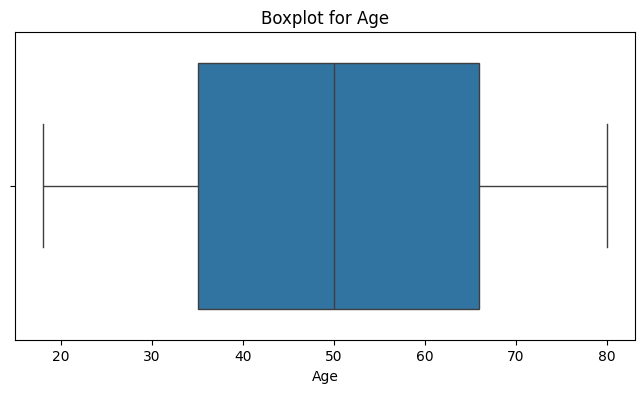


Numerical Column: Purchase_Amount
IQR Outliers in 'Purchase_Amount':
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


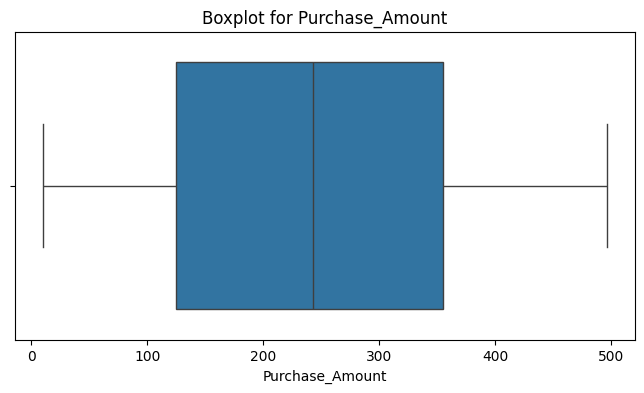


Numerical Column: Average_Spending_Per_Purchase
IQR Outliers in 'Average_Spending_Per_Purchase':
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


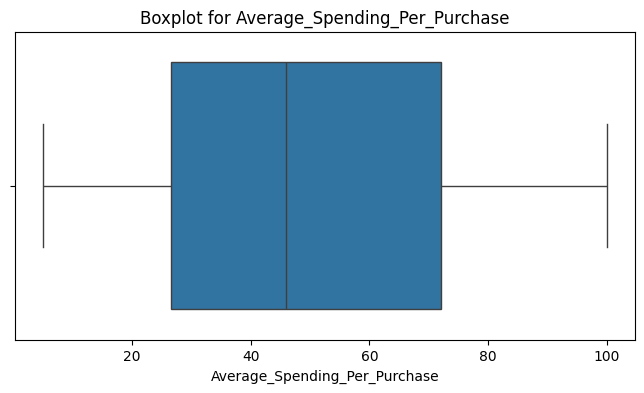


Numerical Column: Purchase_Frequency_Per_Month
IQR Outliers in 'Purchase_Frequency_Per_Month':
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


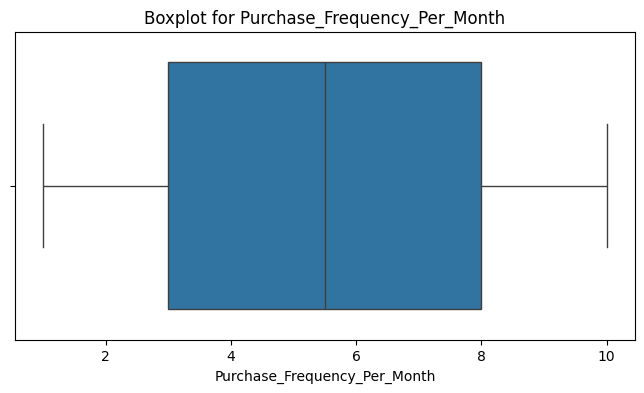


Numerical Column: Brand_Affinity_Score
IQR Outliers in 'Brand_Affinity_Score':
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


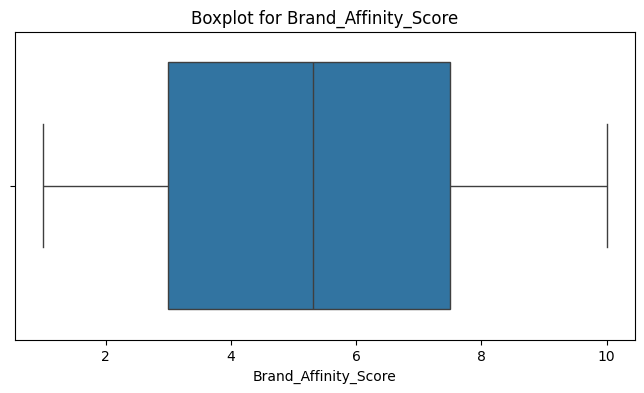


Numerical Column: Month
IQR Outliers in 'Month':
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


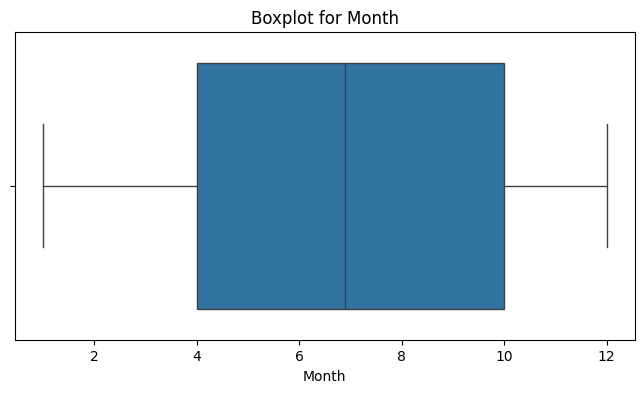


Numerical Column: Year
IQR Outliers in 'Year':
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


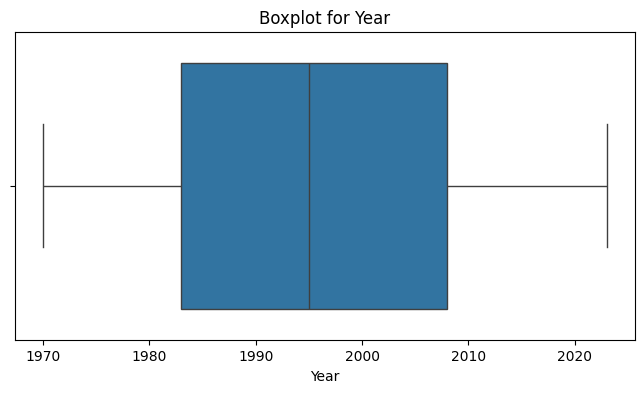


Numerical Column: Will_Purchase_Next_Month
IQR Outliers in 'Will_Purchase_Next_Month':
                               Customer_ID        Age  Gender Income_Level  \
24   0d187b13-1a29-4421-ae2c-c0c378cc8910  19.000000    Male       Medium   
62   02e27bf9-dd37-49ab-8b4c-51b4a7f80284  48.000000   Other       Medium   
72   e3111985-6473-41b9-b5a3-76c6219cb310  45.000000  Female          Low   
80   0d02b3c7-9b57-41e3-9b04-503b608070e0  49.865889  Female         High   
98   b6d90f65-7daf-4847-9e88-14cb2af9a7eb  50.000000    Male          Low   
164  e78baae6-8b0d-4cfb-90fb-8ab59cd569ff  50.000000   Other          Low   
216  e09a26dd-91ff-4b52-8aa8-f09daf1b1f34  42.000000  Female         High   
221  21b11d41-34fb-4961-94cb-b4e65628b9b2  59.000000   Other       Medium   
250  a237c9f1-02ec-4045-a215-5a0814892f56  74.000000   Other          Low   
302  e5e74b98-a190-4d41-9fcc-d48fc8d2b740  76.000000    Male       Medium   
310  4be2e474-fdd2-4f40-9ae1-912a869aedf5  80.000000   Other    

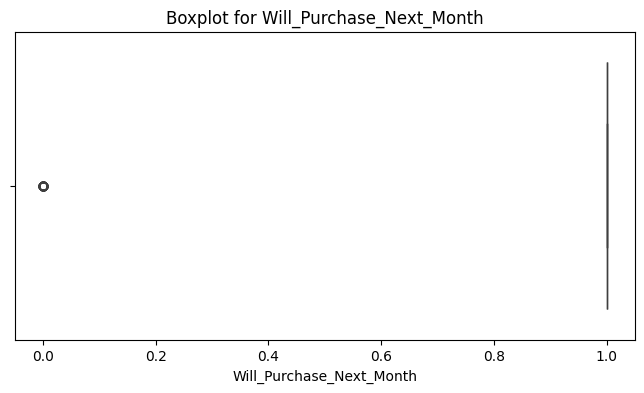


Numerical Column: Income_Level_Num
IQR Outliers in 'Income_Level_Num':
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


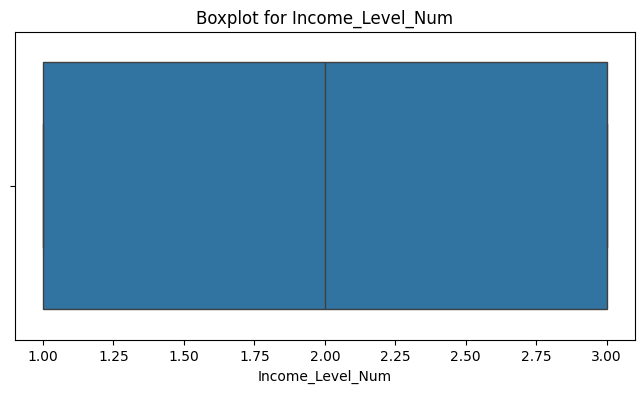


Numerical Column: Is_Summer
IQR Outliers in 'Is_Summer':
                               Customer_ID   Age  Gender Income_Level  \
16   309ab6ee-9364-4a64-9785-77717415ed5f  22.0    Male         High   
17   ffb65cd7-4329-4abb-b076-05eb7cf933e0  68.0  Female          nan   
20   34f7ac8d-fd91-4813-bf4d-e7b18264e442  73.0  Female         High   
24   0d187b13-1a29-4421-ae2c-c0c378cc8910  19.0    Male       Medium   
28   b3edefd3-68f1-4d4c-a182-28ea8231d858  26.0   Other          Low   
..                                    ...   ...     ...          ...   
912  5accb356-f8a7-42c3-8dc5-a97fe338655d  25.0    Male          Low   
928  07c94a26-ceed-4e7e-91d9-79445d0afebb  38.0    Male         High   
942  6341c059-c418-4fb6-a141-0c0d1c878f09  32.0    Male         High   
977  ce940a05-2464-4f0b-bfe5-f0f42cc694fb  37.0  Female          Low   
991  62c73378-cfbf-4896-9243-61de7de9acc7  37.0  Female          Low   

                                               Address  \
16   80014 ayers e

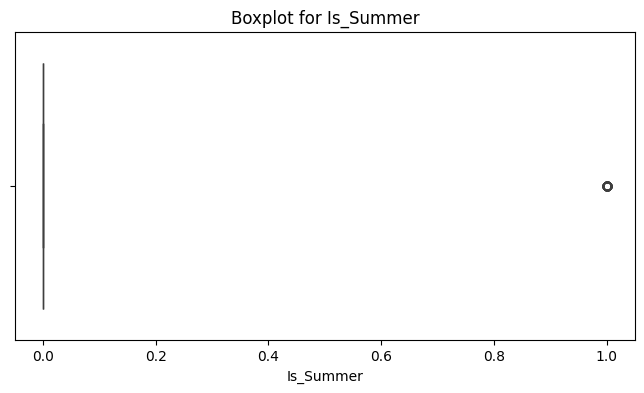


Numerical Column: Is_Winter
IQR Outliers in 'Is_Winter':
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


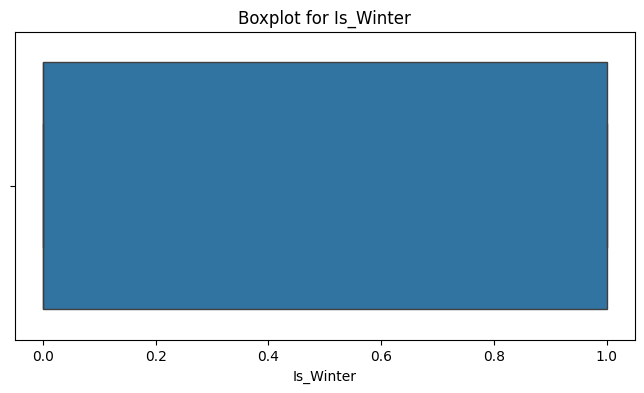


Numerical Column: Is_Spring
IQR Outliers in 'Is_Spring':
                               Customer_ID   Age  Gender Income_Level  \
37   a08cfc43-6894-4e2d-ab24-f3b979870131  54.0     nan       Medium   
48   f3c06ff9-706b-421c-af92-f689c5103a48  34.0    Male          Low   
66   342a6628-4939-4bf9-af9f-160bbc2af784  45.0     nan       Medium   
102  c54f02eb-65a5-40c7-b01b-1c82ce0ddb9a  47.0  Female          Low   
110  140ef8e3-29a7-4603-a9af-6d368ed51737  20.0   Other          Low   
..                                    ...   ...     ...          ...   
974  25666f0c-7c97-4ce7-aa17-5533ad45d291  28.0   Other          Low   
979  93e4ecab-4623-49d5-b677-215639477674  63.0   Other       Medium   
982  53803145-c8e2-4f42-8958-baabcd22b551  23.0  Female         High   
987  ad94ad53-31a3-4223-b900-1fe5239aac1d  59.0    Male       Medium   
990  0a4d6275-f4c9-479d-848e-9ae19eb136fc  38.0   Other         High   

                                               Address  \
37   979 jonathan 

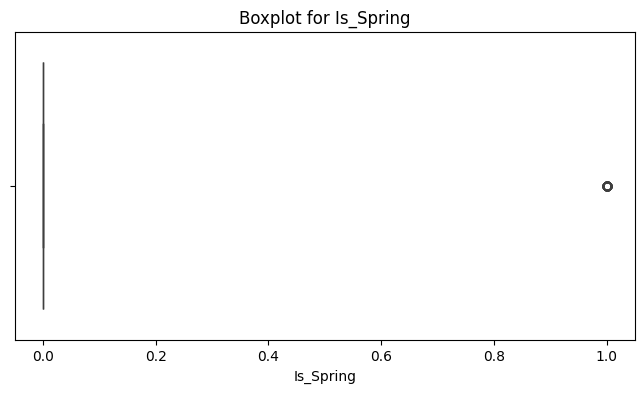


Numerical Column: Is_Fall
IQR Outliers in 'Is_Fall':
                               Customer_ID   Age  Gender Income_Level  \
36   63eb2677-331d-447a-84ce-6cdacaa9697b  49.0   Other         High   
41   1fef3e6a-d744-4e6f-9983-f63848056623  64.0   Other          Low   
43   62d231e3-a9d8-4511-86f8-dc3907b4b012  23.0    Male         High   
46   dfecc88c-862c-4f44-8aad-6db70c360fd4  23.0   Other          Low   
47   6c4791cf-e915-4215-89f3-984b18f4d43b  56.0  Female       Medium   
..                                    ...   ...     ...          ...   
941  4279ef13-e3d0-450f-b962-ab7a162e736f  46.0  Female         High   
946  5aa23c2d-75ce-4a5d-a7bb-3cab375f5cb2  38.0   Other          Low   
988  ae452c82-be49-4f19-a735-5508e05eb37d  50.0    Male       Medium   
993  53c5fb01-3ee3-4cad-beab-fcfa3c03bfe3  57.0    Male       Medium   
995                                   nan  70.0    Male       Medium   

                                               Address  \
36          7033 walte

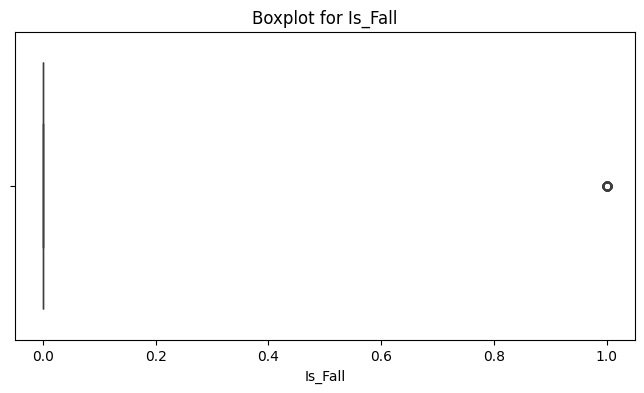


Numerical Column: Total_Spend_Per_Year
IQR Outliers in 'Total_Spend_Per_Year':
                               Customer_ID   Age  Gender Income_Level  \
77   3d209798-2331-4299-82a9-db4df182ee77  75.0    Male          nan   
193  92cc8c4e-0bde-4d6c-aec1-7d2c23ea34dd  48.0   Other       Medium   
245  96690f37-8da5-4805-954c-63ff908fcd85  38.0   Other         High   
281                                   nan  64.0   Other         High   
429  eed702d9-f138-45df-8834-ca49248abd04  60.0   Other       Medium   
671  530794f7-93df-42e5-b922-fc109676a5ca  19.0  Female       Medium   
893  6683455a-d083-4cfe-ad72-f0aa4f639f6e  22.0  Female       Medium   

                                               Address  \
77                                                 nan   
193            00571 hinton forges jonesfurt, ar 63553   
245           88524 ruiz roads cassandrabury, ia 93500   
281  2183 jared mountains suite 869 carolynside, il...   
429      755 lee knolls suite 339 torresview, il 616

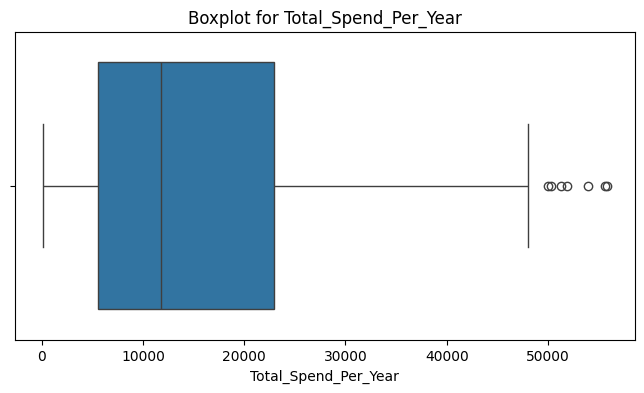


Numerical Column: Recency_Days
IQR Outliers in 'Recency_Days':
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


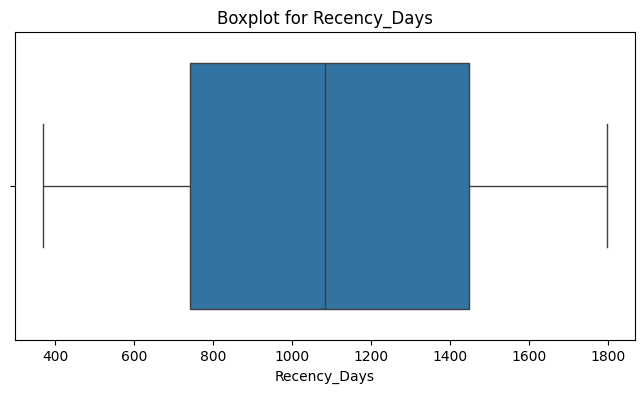


Numerical Column: Spending_vs_Frequency
IQR Outliers in 'Spending_vs_Frequency':
                               Customer_ID   Age  Gender Income_Level  \
2    fdf79bcd-5908-4c90-8501-570ffb5b7648  57.0   Other          Low   
245  96690f37-8da5-4805-954c-63ff908fcd85  38.0   Other         High   
413  773ec6b4-1f1a-46a8-b98e-4d4b414b9ac0  66.0    Male       Medium   
526  4c18d5e0-0fb2-4888-8947-7dcc875f434e  38.0  Female         High   
549  1a2ecc71-c9a0-4660-9dfb-f11e0cf0639d  62.0  Female         High   
743  4f9f1288-910d-4e85-87cd-9914460d93d3  28.0  Female         High   
866  aef13fac-d2b7-471a-b27f-95ae6502145b  64.0     nan         High   

                                               Address  \
2        79683 kevin hill apt. 555 johnshire, ar 39961   
245           88524 ruiz roads cassandrabury, ia 93500   
413            339 robert avenue ashleyburgh, ma 12258   
526  43434 perez ridges apt. 293 lake katherine, nd...   
549    115 shari park suite 427 williamsport, fl 2

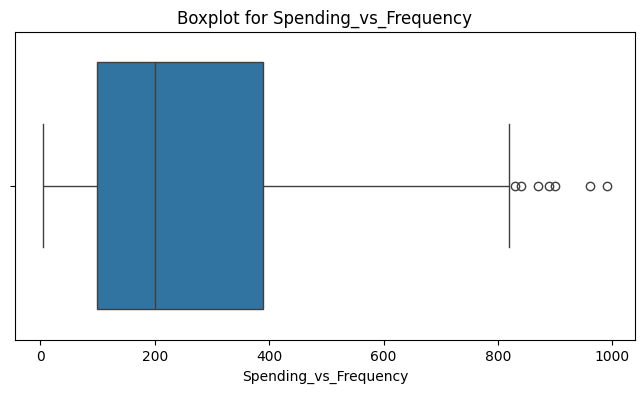


Categorical Column: Gender
Outliers in 'Gender' based on frequency:
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


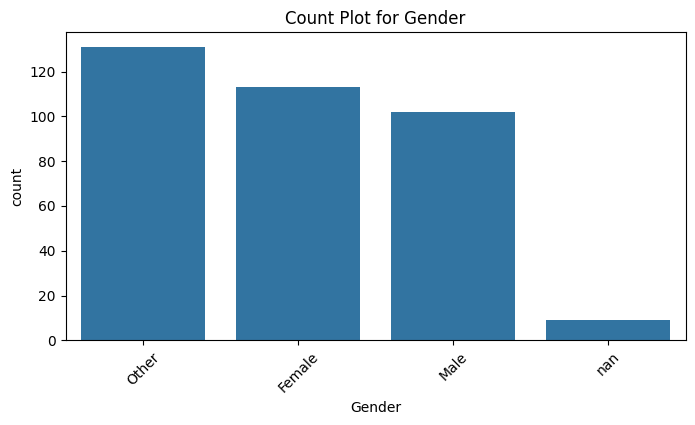


Categorical Column: Income_Level
Outliers in 'Income_Level' based on frequency:
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


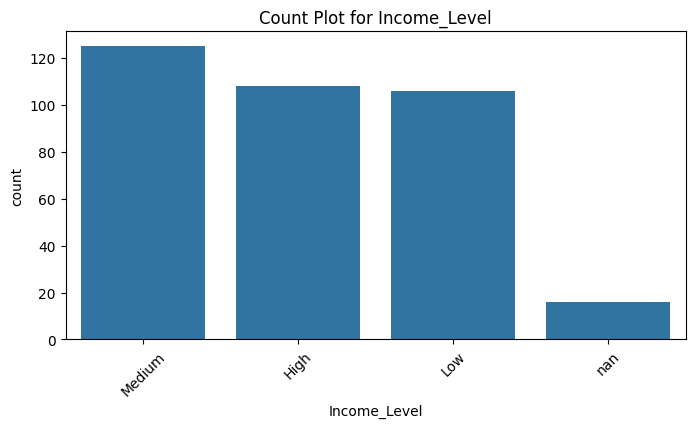


Categorical Column: Product_Category
Outliers in 'Product_Category' based on frequency:
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


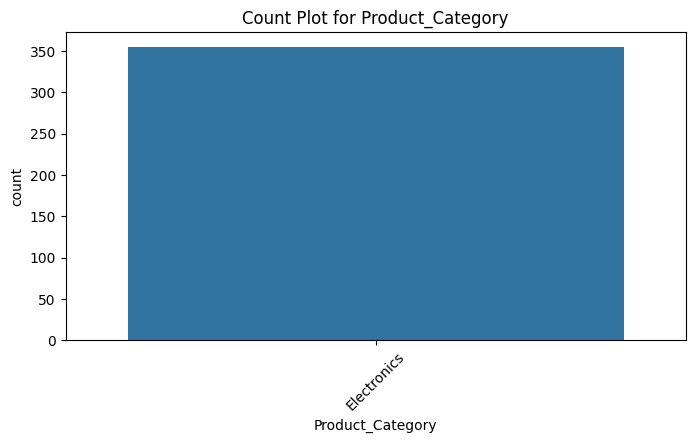


Categorical Column: Brand
Outliers in 'Brand' based on frequency:
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


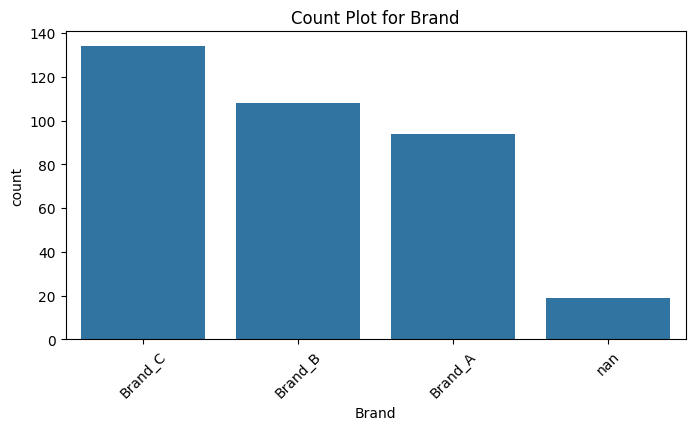


Categorical Column: Product_Category_Preferences
Outliers in 'Product_Category_Preferences' based on frequency:
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


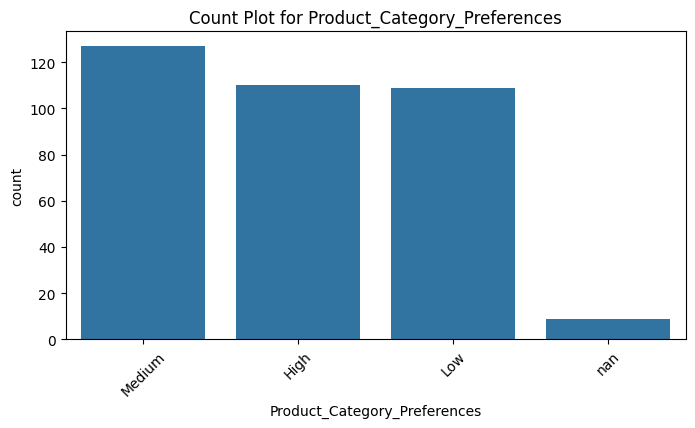


Categorical Column: Season
Outliers in 'Season' based on frequency:
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


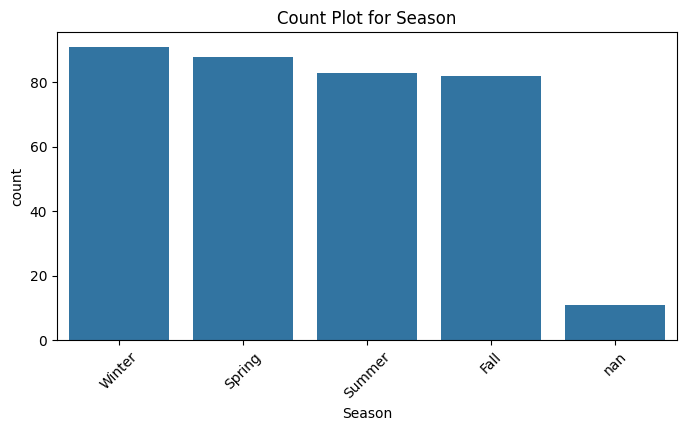


Categorical Column: Age_Group
Outliers in 'Age_Group' based on frequency:
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


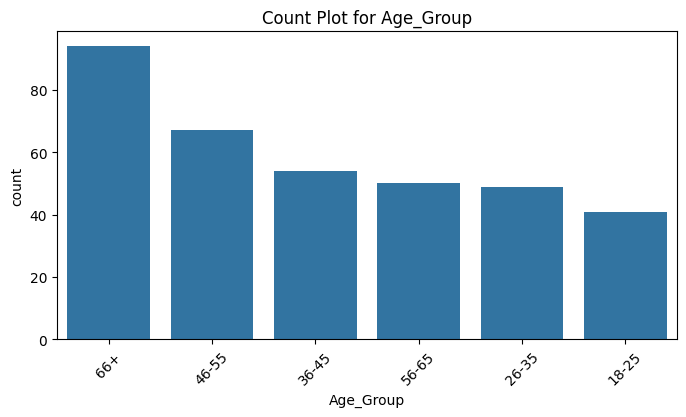


Categorical Column: Brand_Affinity_Category
Outliers in 'Brand_Affinity_Category' based on frequency:
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


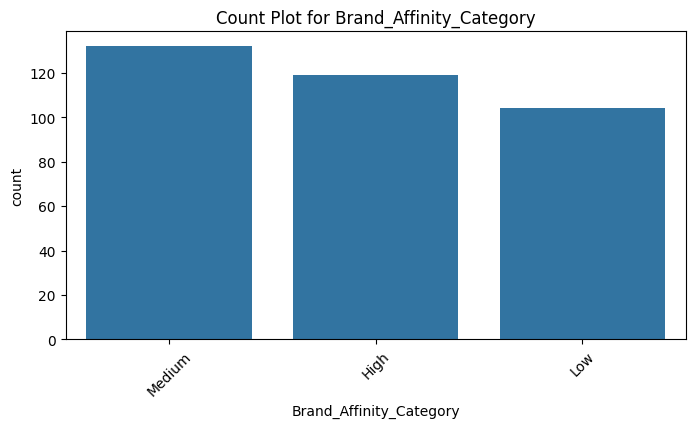


Categorical Column: Purchase_Behavior
Outliers in 'Purchase_Behavior' based on frequency:
 Empty DataFrame
Columns: [Customer_ID, Age, Gender, Income_Level, Address, Transaction_ID, Purchase_Date, Product_ID, Product_Category, Brand, Purchase_Amount, Average_Spending_Per_Purchase, Purchase_Frequency_Per_Month, Brand_Affinity_Score, Product_Category_Preferences, Month, Year, Season, Will_Purchase_Next_Month, Age_Group, Income_Level_Num, Is_Summer, Is_Winter, Is_Spring, Is_Fall, Brand_Affinity_Category, Purchase_Behavior, Total_Spend_Per_Year, Recency_Days, Spending_vs_Frequency]
Index: []

[0 rows x 30 columns]


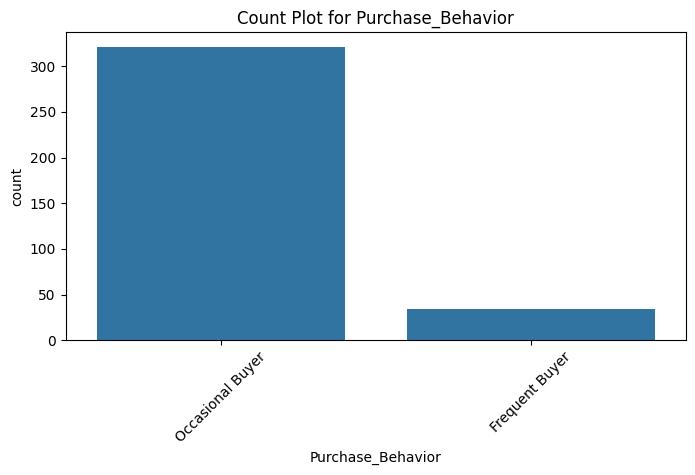

In [ ]:
# Detecting Outliers in Numerical Columns Using IQR
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

# Detecting Outliers in Categorical Columns Based on Frequency
def detect_outliers_categorical(df, col, threshold=5):
    value_counts = df[col].value_counts()
    rare_values = value_counts[value_counts < threshold].index
    return df[df[col].isin(rare_values)]

# Separate columns by type
numerical_cols = df.select_dtypes(include=["number"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

# Exclude specific columns from the categorical columns for count plotting
exclude_columns = ['Customer_ID', 'Address', 'Product_ID', 'Transaction_ID']
categorical_cols = [col for col in categorical_cols if col not in exclude_columns]

# Outlier detection for numerical columns using IQR
for col in numerical_cols:
    print(f"\nNumerical Column: {col}")
    # Using IQR method
    iqr_outliers = detect_outliers_iqr(df, col)
    print(f"IQR Outliers in '{col}':\n", iqr_outliers)

    # Plot boxplot to visualize outliers
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

# Outlier detection for categorical columns
for col in categorical_cols:
    print(f"\nCategorical Column: {col}")
    # Detect outliers based on frequency
    categorical_outliers = detect_outliers_categorical(df, col)
    print(f"Outliers in '{col}' based on frequency:\n", categorical_outliers)

    # Plot countplot to visualize distribution
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[col], order=df[col].value_counts().index)
    plt.title(f"Count Plot for {col}")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Dictionary of abbreviations and standardizations for common address terms
address_abbr_dict = {
    'street': 'st', 'avenue': 'ave', 'road': 'rd', 'drive': 'dr', 'boulevard': 'blvd',
    'lane': 'ln', 'court': 'ct', 'parkway': 'pkwy', 'circle': 'cir', 'apartment': 'apt',
    'suite': 'ste', 'unit': 'unit', 'floor': 'fl', 'box': 'pobox', 'postal': 'zip', 'district': 'dist',
    'avenue': 'ave', 'blvd': 'blvd', 'st': 'st', 'sq': 'square', 'plaza': 'plz', 'alley': 'aly', 'way': 'wy'
}

# Function to clean and standardize the 'Address' column
def clean_address_column(df, col):
    # Remove leading/trailing spaces and normalize case
    df[col] = df[col].str.strip().str.lower()

    # Replace newline characters with a space
    df[col] = df[col].str.replace("\n", " ")

    # Remove non-ASCII characters by normalizing to closest ASCII equivalents
    df[col] = df[col].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('ascii'))

    # Replace common address words with their abbreviations
    for key, value in address_abbr_dict.items():
        # Using word boundaries to ensure correct replacements
        df[col] = df[col].str.replace(r'\b' + key + r'\b', value)

    # Remove any extra spaces left over after replacements
    df[col] = df[col].str.replace(r'\s+', ' ', regex=True)

# Clean the 'Address' column
clean_address_column(df, 'Address')

# Check the cleaned Address column
print(df[['Address']])

                                               Address
2        79683 kevin hill apt. 555 johnshire, ar 39961
15      8072 dean bypass suite 774 chloebury, al 01960
16   80014 ayers extension apt. 361 smithtown, wy 5...
17         7417 gregory garden jordanborough, mt 88106
20       12604 mcdowell canyon new angelview, tn 16808
..                                                 ...
988  0587 roger village suite 169 east meganton, de...
990                    unit 7320 box 3586 dpo aa 76845
991        91116 bradley islands west meghan, pr 35083
993       7406 pugh roads apt. 254 beardfurt, ma 17468
995           566 butler turnpike port holly, ok 22329

[355 rows x 1 columns]


In [ ]:
#cleaneddata
df.head()

,Customer_ID,Age,Gender,Income_Level,Address,Transaction_ID,Purchase_Date,Product_ID,Product_Category,Brand,...,Income_Level_Num,Is_Summer,Is_Winter,Is_Spring,Is_Fall,Brand_Affinity_Category,Purchase_Behavior,Total_Spend_Per_Year,Recency_Days,Spending_vs_Frequency
2,fdf79bcd-5908-4c90-8501-570ffb5b7648,57.0,Other,Low,"79683 kevin hill apt. 555 johnshire, ar 39961",462925b1-a5bf-4996-bda2-59749de64eea,2021-12-09,9ab75a68-4329-4bd9-a259-2233c0f34c93,Electronics,Brand_A,...,1.0,0,1,0,0,Low,Occasional Buyer,21276.0,1091.0,900.0
15,2e74b84d-d06c-4920-a3a9-38e4a11e8da8,54.0,Male,High,"8072 dean bypass suite 774 chloebury, al 01960",4c45da65-bd62-486e-aeff-31f8959e0987,2023-06-03,e47f58c8-c6e9-40ed-9ce8-31af73b91fb5,Electronics,Brand_B,...,3.0,0,1,0,0,Low,Frequent Buyer,32640.0,550.0,180.0
16,309ab6ee-9364-4a64-9785-77717415ed5f,22.0,Male,High,"80014 ayers extension apt. 361 smithtown, wy 5...",62001db5-24fa-49d8-b570-928124a181d9,2022-01-07,b66cae99-a5b0-4ca9-9aff-6f57ff1bf421,Electronics,nan,...,3.0,1,0,0,0,Medium,Occasional Buyer,23136.0,1062.0,208.0
17,ffb65cd7-4329-4abb-b076-05eb7cf933e0,68.0,Female,nan,"7417 gregory garden jordanborough, mt 88106",27a18611-855f-4db3-ad4e-77b008695f09,2022-06-25,nan,Electronics,Brand_B,...,NaN,1,0,0,0,Medium,Occasional Buyer,5520.0,893.0,124.0
20,34f7ac8d-fd91-4813-bf4d-e7b18264e442,73.0,Female,High,"12604 mcdowell canyon new angelview, tn 16808",b6c5589a-483a-403f-9cf2-b0ae77b15fbf,2021-11-27,70729d29-d37a-4bda-9081-c49d9dd47f30,Electronics,Brand_C,...,3.0,1,0,0,0,High,Occasional Buyer,8880.0,1103.0,26.0


**Data Transformation:**

In [ ]:

# Feature Engineering
# 1. Age Group
def age_group(age):
    if age <= 25:
        return '18-25'
    elif 26 <= age <= 35:
        return '26-35'
    elif 36 <= age <= 45:
        return '36-45'
    elif 46 <= age <= 55:
        return '46-55'
    elif 56 <= age <= 65:
        return '56-65'
    else:
        return '66+'

df['Age_Group'] = df['Age'].apply(age_group)

# 2. Income Level Group (for simplicity, we can assign numerical values to income levels)
income_map = {'Low': 1, 'Medium': 2, 'High': 3}
df['Income_Level_Num'] = df['Income_Level'].map(income_map)

# 3. Season Binaries
df['Is_Summer'] = (df['Season'] == 'Summer').astype(int)
df['Is_Winter'] = (df['Season'] == 'Winter').astype(int)
df['Is_Spring'] = (df['Season'] == 'Spring').astype(int)
df['Is_Fall'] = (df['Season'] == 'Fall').astype(int)

# 4. Brand Affinity Score Category
def brand_affinity_category(score):
    if score <= 3:
        return 'Low'
    elif 4 <= score <= 6:
        return 'Medium'
    else:
        return 'High'

df['Brand_Affinity_Category'] = df['Brand_Affinity_Score'].apply(brand_affinity_category)

# 5. Monthly Purchase Behavior
def purchase_behavior(frequency):
    if frequency >= 10:
        return 'Frequent Buyer'
    else:
        return 'Occasional Buyer'

df['Purchase_Behavior'] = df['Purchase_Frequency_Per_Month'].apply(purchase_behavior)

# 6. Total Spend per Year
df['Total_Spend_Per_Year'] = df['Purchase_Amount'] * df['Purchase_Frequency_Per_Month'] * 12

# 7. Recency of Purchase (how recent the last purchase is)
current_date = datetime.today()
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'])
df['Recency_Days'] = (current_date - df['Purchase_Date']).dt.days

# 8. Spending vs. Frequency
df['Spending_vs_Frequency'] = df['Average_Spending_Per_Purchase'] * df['Purchase_Frequency_Per_Month']

# Display the DataFrame with the new features
df.head()

,Customer_ID,Age,Gender,Income_Level,Address,Transaction_ID,Purchase_Date,Product_ID,Product_Category,Brand,...,Income_Level_Num,Is_Summer,Is_Winter,Is_Spring,Is_Fall,Brand_Affinity_Category,Purchase_Behavior,Total_Spend_Per_Year,Recency_Days,Spending_vs_Frequency
purchase_date,,,,,,,,,,,,,,,,,,,,,
2021-12-09,fdf79bcd-5908-4c90-8501-570ffb5b7648,57.0,Other,Low,"79683 kevin hill apt. 555 johnshire, ar 39961",462925b1-a5bf-4996-bda2-59749de64eea,2021-12-09,9ab75a68-4329-4bd9-a259-2233c0f34c93,Electronics,Brand_A,...,1.0,0,1,0,0,Low,Occasional Buyer,21276.0,1091,900.0
2023-06-03,2e74b84d-d06c-4920-a3a9-38e4a11e8da8,54.0,Male,High,"8072 dean bypass suite 774 chloebury, al 01960",4c45da65-bd62-486e-aeff-31f8959e0987,2023-06-03,e47f58c8-c6e9-40ed-9ce8-31af73b91fb5,Electronics,Brand_B,...,3.0,0,1,0,0,Low,Frequent Buyer,32640.0,550,180.0
2022-01-07,309ab6ee-9364-4a64-9785-77717415ed5f,22.0,Male,High,"80014 ayers extension apt. 361 smithtown, wy 5...",62001db5-24fa-49d8-b570-928124a181d9,2022-01-07,b66cae99-a5b0-4ca9-9aff-6f57ff1bf421,Electronics,nan,...,3.0,1,0,0,0,Medium,Occasional Buyer,23136.0,1062,208.0
2022-06-25,ffb65cd7-4329-4abb-b076-05eb7cf933e0,68.0,Female,nan,"7417 gregory garden jordanborough, mt 88106",27a18611-855f-4db3-ad4e-77b008695f09,2022-06-25,nan,Electronics,Brand_B,...,NaN,1,0,0,0,Medium,Occasional Buyer,5520.0,893,124.0
2021-11-27,34f7ac8d-fd91-4813-bf4d-e7b18264e442,73.0,Female,High,"12604 mcdowell canyon new angelview, tn 16808",b6c5589a-483a-403f-9cf2-b0ae77b15fbf,2021-11-27,70729d29-d37a-4bda-9081-c49d9dd47f30,Electronics,Brand_C,...,3.0,1,0,0,0,High,Occasional Buyer,8880.0,1103,26.0


**Module 2: Exploratory Data Analysis (EDA):**

In [ ]:
#descriptive statistics
print("Customer Age Statistics:")
print(df["Age"].describe())
print("\nPurchase Amount Statistics:")
print(df["Purchase_Amount"].describe())
print("\nPurchase Frequency per Month")
print(df["Purchase_Frequency_Per_Month"].describe())

Customer Age Statistics:
count    355.000000
mean      49.464789
std       18.236853
min       18.000000
25%       35.000000
50%       50.000000
75%       66.000000
max       80.000000
Name: Age, dtype: float64

Purchase Amount Statistics:
count    355.000000
mean     241.735211
std      136.485312
min       10.000000
25%      124.500000
50%      222.000000
75%      354.500000
max      496.000000
Name: Purchase_Amount, dtype: float64

Purchase Frequency per Month
count    355.000000
mean       5.307042
std        2.889457
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       10.000000
Name: Purchase_Frequency_Per_Month, dtype: float64


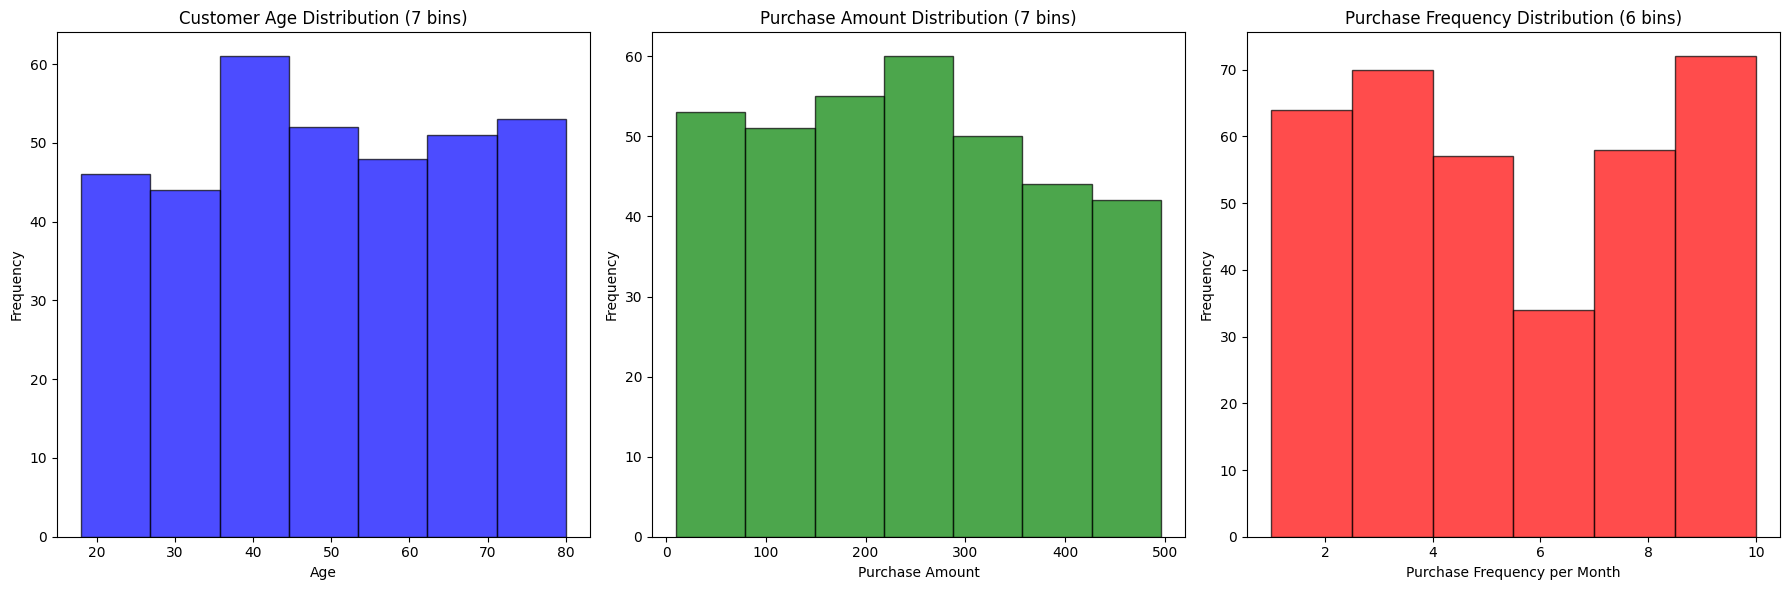

In [ ]:
# Function to calculate bins using Freedman-Diaconis rule
def freedman_diaconis_bins(data):
    if len(data) < 2:  # Handle cases with insufficient data
        return 1
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25  # Interquartile range
    bin_width = 2 * iqr / (len(data) ** (1 / 3))  # Bin width
    if bin_width == 0:  # Handle case where IQR = 0
        return 10
    bins = int((data.max() - data.min()) / bin_width)  # Number of bins
    return max(1, bins)

# Drop rows with NaN values after ensuring columns are numeric
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Purchase_Amount'] = pd.to_numeric(df['Purchase_Amount'], errors='coerce')
df['Purchase_Frequency_Per_Month'] = pd.to_numeric(df['Purchase_Frequency_Per_Month'], errors='coerce')
df = df.dropna(subset=['Age', 'Purchase_Amount', 'Purchase_Frequency_Per_Month'])

# Ensure there is data after cleaning
if df.empty:
    raise ValueError("The dataset is empty after cleaning. Please check the input data.")

# Calculate number of bins for each column
bins_age = freedman_diaconis_bins(df['Age'])
bins_purchase_amount = freedman_diaconis_bins(df['Purchase_Amount'])
bins_purchase_frequency = freedman_diaconis_bins(df['Purchase_Frequency_Per_Month'])

# Plot histograms using Freedman-Diaconis bins
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(df['Age'], bins=bins_age, color='blue', alpha=0.7, edgecolor='black')
plt.title(f'Customer Age Distribution ({bins_age} bins)')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df['Purchase_Amount'], bins=bins_purchase_amount, color='green', alpha=0.7, edgecolor='black')
plt.title(f'Purchase Amount Distribution ({bins_purchase_amount} bins)')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(df['Purchase_Frequency_Per_Month'], bins=bins_purchase_frequency, color='red', alpha=0.7, edgecolor='black')
plt.title(f'Purchase Frequency Distribution ({bins_purchase_frequency} bins)')
plt.xlabel('Purchase Frequency per Month')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Skewness of each column
skewness_age = df['Age'].skew()
skewness_purchase_amount = df['Purchase_Amount'].skew()
skewness_purchase_frequency = df['Purchase_Frequency_Per_Month'].skew()

print(f'Skewness for Age: {skewness_age}')
print(f'Skewness for Purchase Amount: {skewness_purchase_amount}')
print(f'Skewness for Purchase Frequency: {skewness_purchase_frequency}')


Skewness for Age: 0.0009745230148944301
Skewness for Purchase Amount: 0.12332137306629595
Skewness for Purchase Frequency: 0.18068126585538166


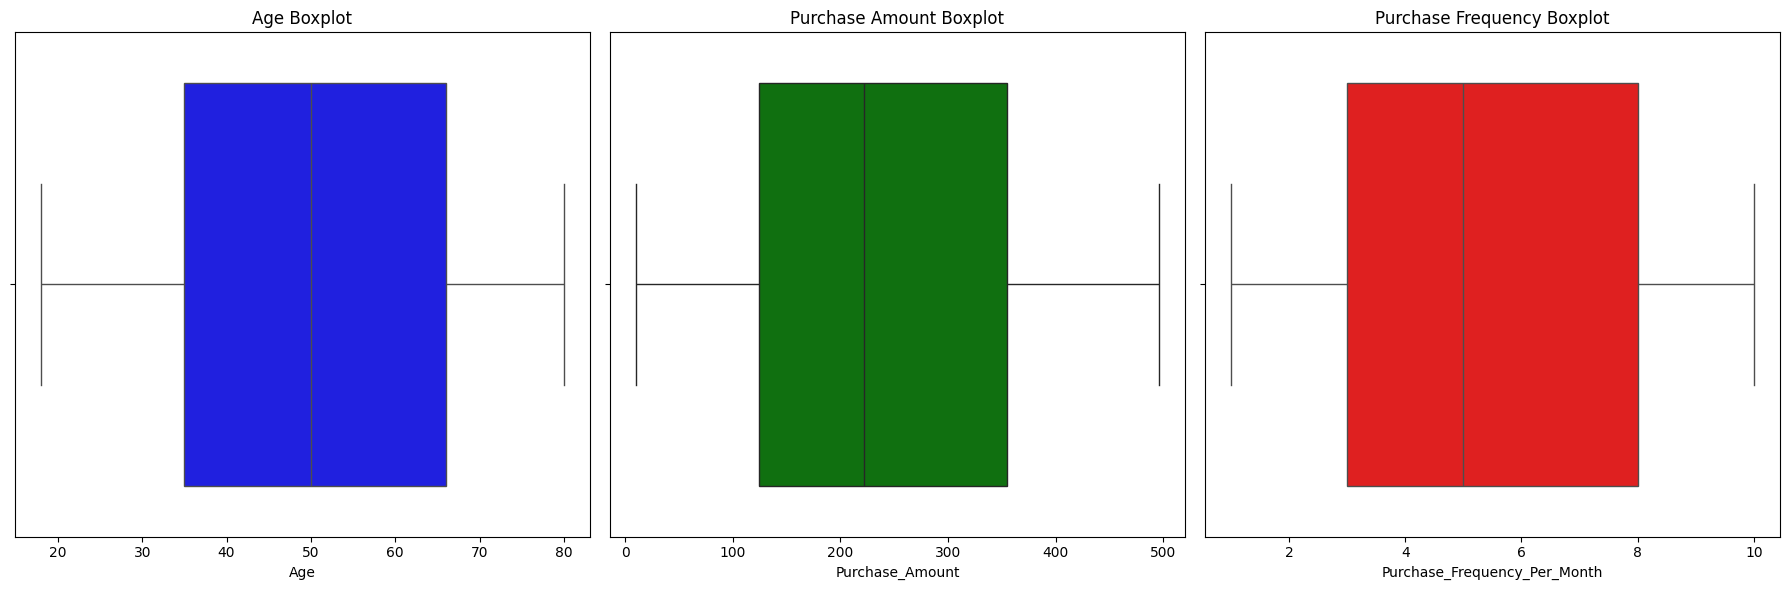

In [ ]:
plt.figure(figsize=(18, 6))

# Boxplot for Age
plt.subplot(1, 3, 1)
sns.boxplot(x=df['Age'], color='blue')
plt.title('Age Boxplot')

# Boxplot for Purchase Amount
plt.subplot(1, 3, 2)
sns.boxplot(x=df['Purchase_Amount'], color='green')
plt.title('Purchase Amount Boxplot')

# Boxplot for Purchase Frequency
plt.subplot(1, 3, 3)
sns.boxplot(x=df['Purchase_Frequency_Per_Month'], color='red')
plt.title('Purchase Frequency Boxplot')

plt.tight_layout()
plt.show()


**2. Bivariate Analysis:**

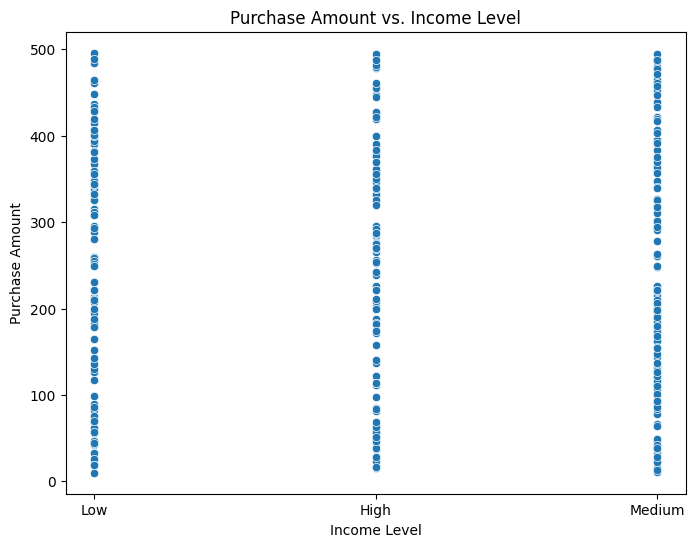

In [ ]:
plt.figure(figsize=(8, 6))

sns.scatterplot(x='Income_Level', y='Purchase_Amount', data=df)
plt.title("Purchase Amount vs. Income Level")
plt.xlabel("Income Level")
plt.ylabel("Purchase Amount")
plt.show()

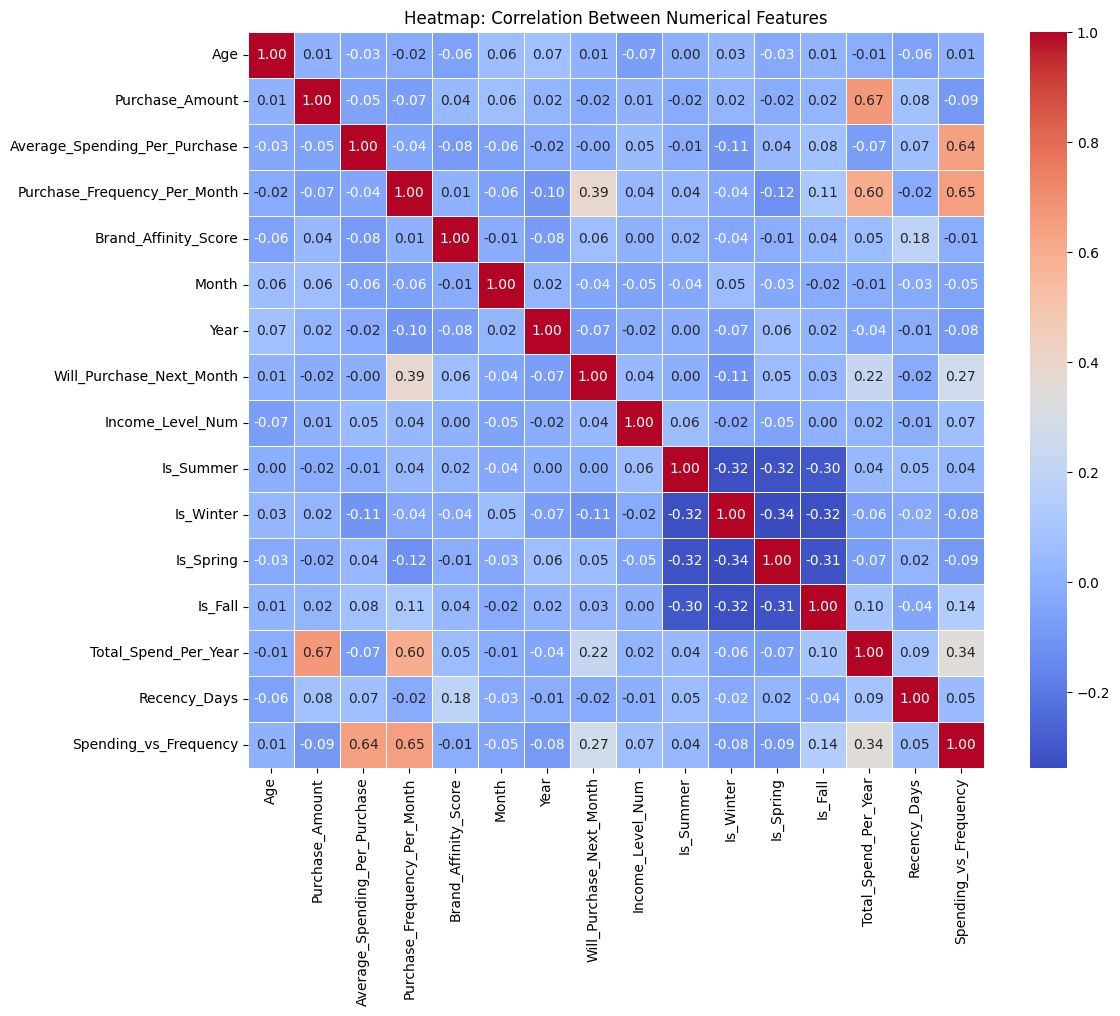

In [ ]:
#picking only numrical values
numerical_cols = df.select_dtypes(include=["number"]).columns

# Compute the correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True)
plt.title("Heatmap: Correlation Between Numerical Features")
plt.tight_layout()
plt.show()


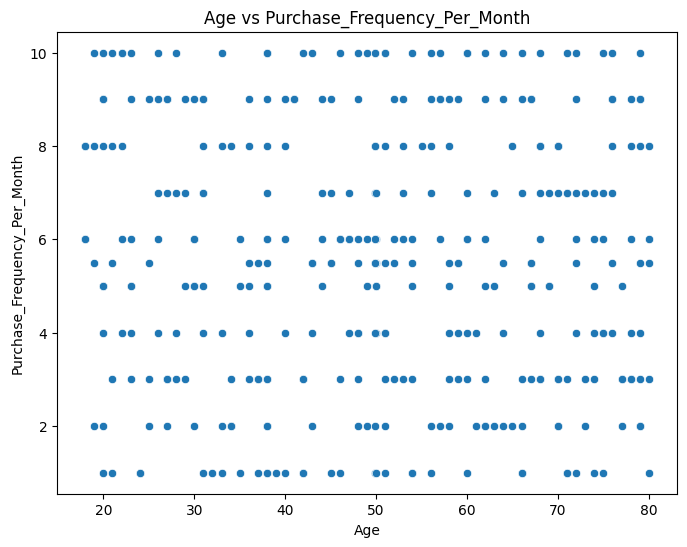

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age', y='Purchase_Frequency_Per_Month', data=df)
plt.title("Age vs Purchase_Frequency_Per_Month")
plt.xlabel("Age")
plt.ylabel("Purchase_Frequency_Per_Month")
plt.show()

In [78]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'purchase_date' is a column in datetime format
df['purchase_date'] = pd.to_datetime(df['Purchase_Date'])

# Set 'purchase_date' as the index for time-based operations
df.set_index('purchase_date', inplace=True)

# Handle missing values in Product_Category if necessary
df['Product_Category'] = df['Product_Category'].fillna('Unknown')  # Replace missing with a default value (if appropriate)

# Resample the data on a monthly basis (Month-end resampling with 'ME')
monthly_data = df.resample('ME').agg({
    'Purchase_Amount': 'mean',  # Average spending per month
    'Purchase_Frequency_Per_Month': 'mean',  # Average frequency per month
    'Product_Category': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
})

# Display the first few rows
print(monthly_data.head())


               Purchase_Amount  Purchase_Frequency_Per_Month Product_Category
purchase_date                                                                
2020-01-31          242.700000                      3.600000      Electronics
2020-02-29          255.715976                      5.876147      Electronics
2020-03-31          283.017524                      4.923430      Electronics
2020-04-30          213.222222                      5.611621      Electronics
2020-05-31          256.375000                      5.125000      Electronics


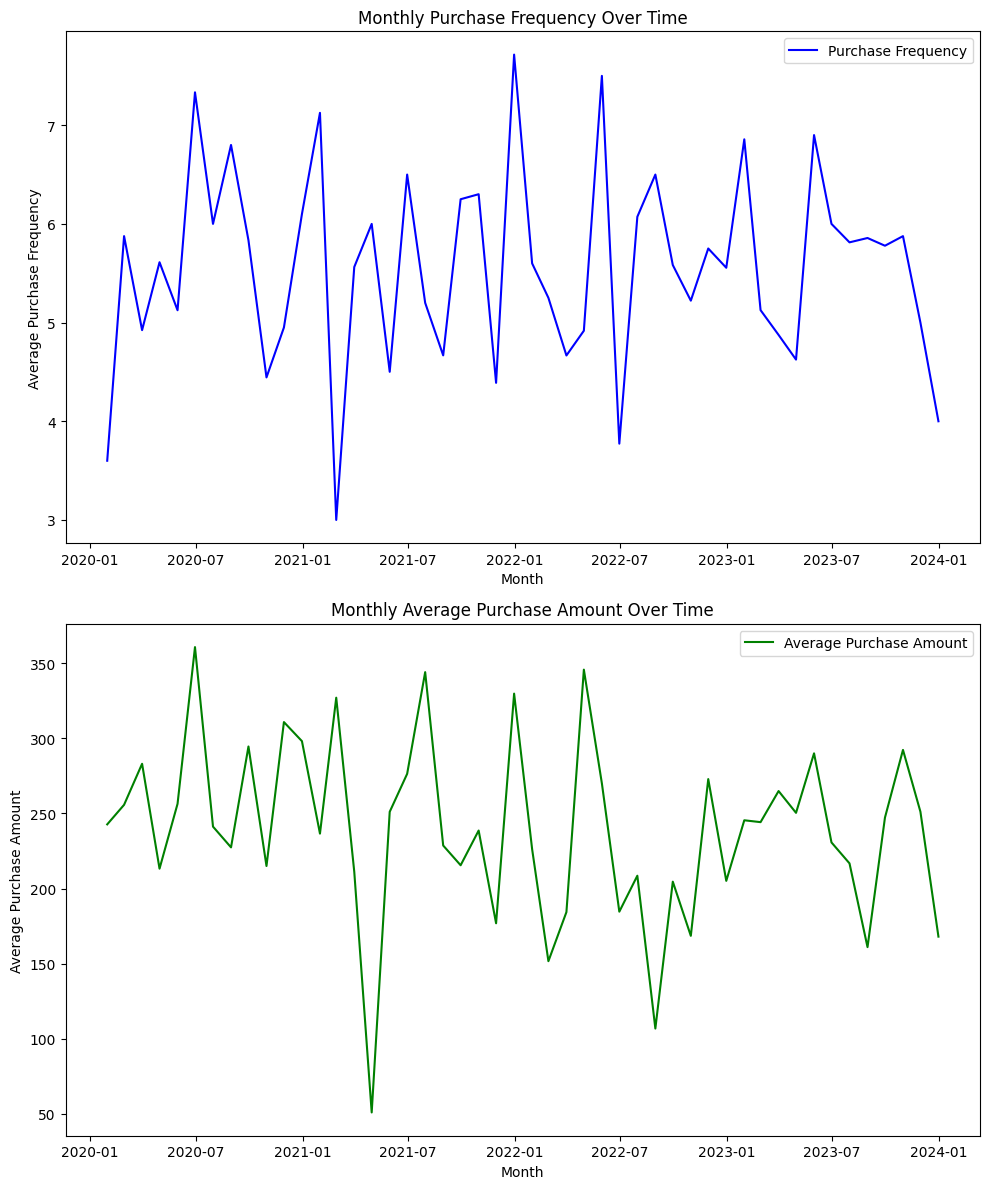

In [79]:
import matplotlib.pyplot as plt

# Ensure 'monthly_data' has appropriate columns and index
# If 'monthly_data' doesn't have datetime index, you may want to convert it to datetime first
# monthly_data['Month'] = pd.to_datetime(monthly_data['Month'])  # if you need to convert 'Month' column

# Plot trends in purchase frequency, average spending, and product category preference
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plotting average purchase frequency over time
ax[0].plot(monthly_data.index, monthly_data['Purchase_Frequency_Per_Month'], label='Purchase Frequency', color='blue')
ax[0].set_title('Monthly Purchase Frequency Over Time')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Average Purchase Frequency')
ax[0].legend()

# Plotting average purchase amount over time
ax[1].plot(monthly_data.index, monthly_data['Purchase_Amount'], label='Average Purchase Amount', color='green')
ax[1].set_title('Monthly Average Purchase Amount Over Time')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Average Purchase Amount')
ax[1].legend()

plt.tight_layout()
plt.show()


<ipython-input-80-b995e1513e8c>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data['Purchase_Frequency_Per_Month'] = monthly_data['Purchase_Frequency_Per_Month'].fillna(method='ffill')


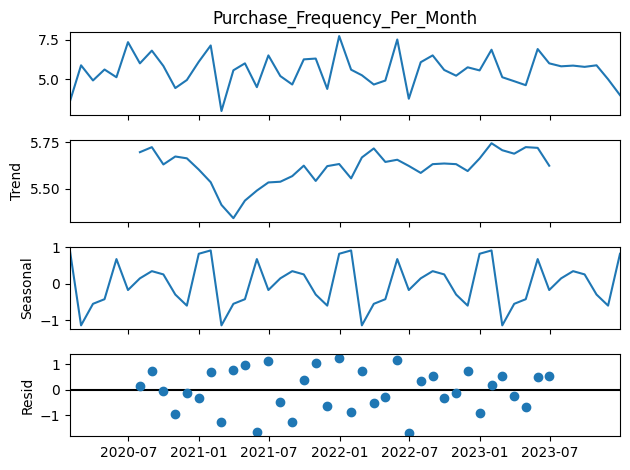

In [80]:

# Ensure the 'Purchase_Frequency_Per_Month' is numeric
monthly_data['Purchase_Frequency_Per_Month'] = pd.to_numeric(monthly_data['Purchase_Frequency_Per_Month'], errors='coerce')

# Fill any NaN values after ensuring numeric conversion (if any invalid data was present)
monthly_data['Purchase_Frequency_Per_Month'] = monthly_data['Purchase_Frequency_Per_Month'].fillna(method='ffill')

# Ensure there are no missing values left
assert monthly_data['Purchase_Frequency_Per_Month'].isnull().sum() == 0, "There are still missing values in the column."

# Decompose the monthly purchase frequency data
result = seasonal_decompose(monthly_data['Purchase_Frequency_Per_Month'], model='additive', period=12)  # 'period' sets seasonality, e.g., monthly for 12 months

# Plot the decomposition
result.plot()
plt.show()


**Module 3: Regression and Decision Tree Analysis:**

In [81]:

# Encode categorical variables
df['Income_Level'] = pd.Categorical(df['Income_Level']).codes
df['Product_Category'] = pd.Categorical(df['Product_Category']).codes

# Select features and target variable
X = df[['Income_Level', 'Age', 'Product_Category']]  # Predictor variables
y = df['Purchase_Amount']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")


Mean Absolute Error (MAE): 122.72840066235008
Mean Squared Error (MSE): 20796.435723347302
R-squared: 0.0007900422501796456


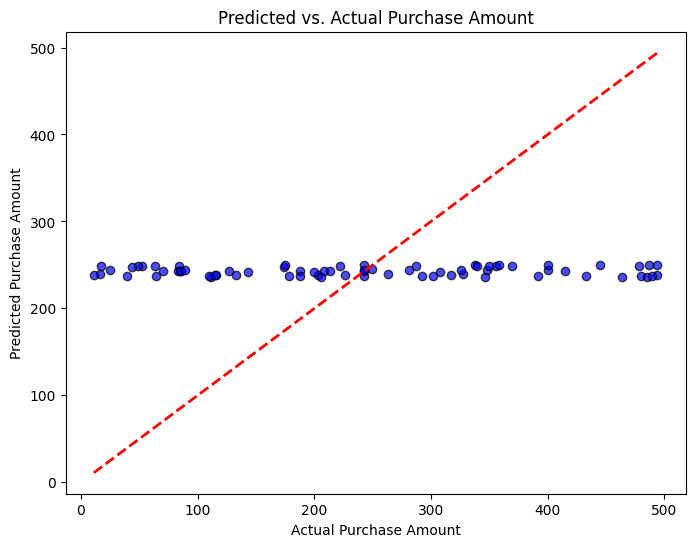

In [82]:
# Scatter plot of Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel("Actual Purchase Amount")
plt.ylabel("Predicted Purchase Amount")
plt.title("Predicted vs. Actual Purchase Amount")
plt.show()


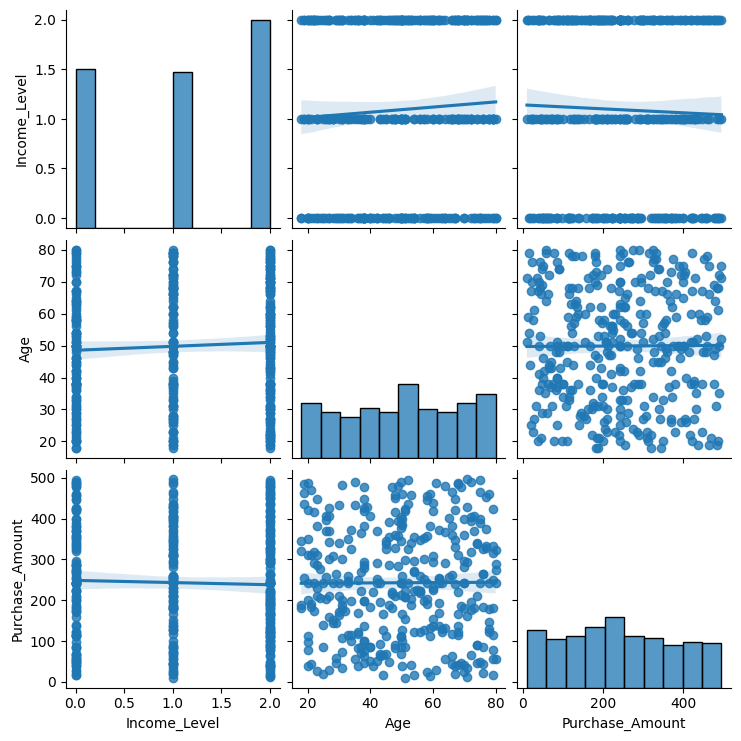

In [83]:
# Pairplot with regression lines for each variable
sns.pairplot(df[['Income_Level', 'Age', 'Purchase_Amount']], kind='reg')
plt.show()


**B. Decision Tree Analysis:**

In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Data Preprocessing
# Select relevant features and target
features = [
    "Average_Spending_Per_Purchase",
    "Brand_Affinity_Score",
    "Purchase_Amount"
]
target = "Will_Purchase_Next_Month"

# Convert columns to numeric, handling missing or invalid values
for col in features + [target]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Handle missing values
# Impute feature columns with their mean
df[features] = df[features].fillna(df[features].mean())

# Drop rows where the target is missing (since we can't predict without a target)
df = df.dropna(subset=[target])

# Feature Matrix (X) and Target Vector (y)
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print("\nTraining and Testing Data Shapes:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# Decision Tree Classifier Training
dt_classifier = DecisionTreeClassifier(criterion="gini", random_state=42)
dt_classifier.fit(X_train, y_train)

print("\nModel training complete.")



Training and Testing Data Shapes:
X_train: (284, 3), X_test: (71, 3)
y_train: (284,), y_test: (71,)

Model training complete.


In [95]:

# Predict on the test set
y_pred = dt_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="binary")
recall = recall_score(y_test, y_pred, average="binary")
f1 = f1_score(y_test, y_pred, average="binary")

# Display evaluation metrics
print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}\n")

# Detailed classification report
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred))

# Display the decision tree structure as text
tree_rules = export_text(dt_classifier, feature_names=features)
print("\nDecision Tree Rules:")
print(tree_rules)



Model Evaluation Metrics:
Accuracy: 0.68
Precision: 0.78
Recall: 0.82
F1 Score: 0.80

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.07      0.08        14
           1       0.78      0.82      0.80        57

    accuracy                           0.68        71
   macro avg       0.44      0.45      0.44        71
weighted avg       0.65      0.68      0.66        71


Decision Tree Rules:
|--- Purchase_Amount <= 22.50
|   |--- Purchase_Amount <= 17.50
|   |   |--- class: 1
|   |--- Purchase_Amount >  17.50
|   |   |--- class: 0
|--- Purchase_Amount >  22.50
|   |--- Purchase_Amount <= 235.00
|   |   |--- Purchase_Amount <= 115.50
|   |   |   |--- Average_Spending_Per_Purchase <= 46.50
|   |   |   |   |--- Average_Spending_Per_Purchase <= 10.00
|   |   |   |   |   |--- Purchase_Amount <= 93.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Purchase_Amount >  93.50
|   |   |   |   |   |   |--- cla

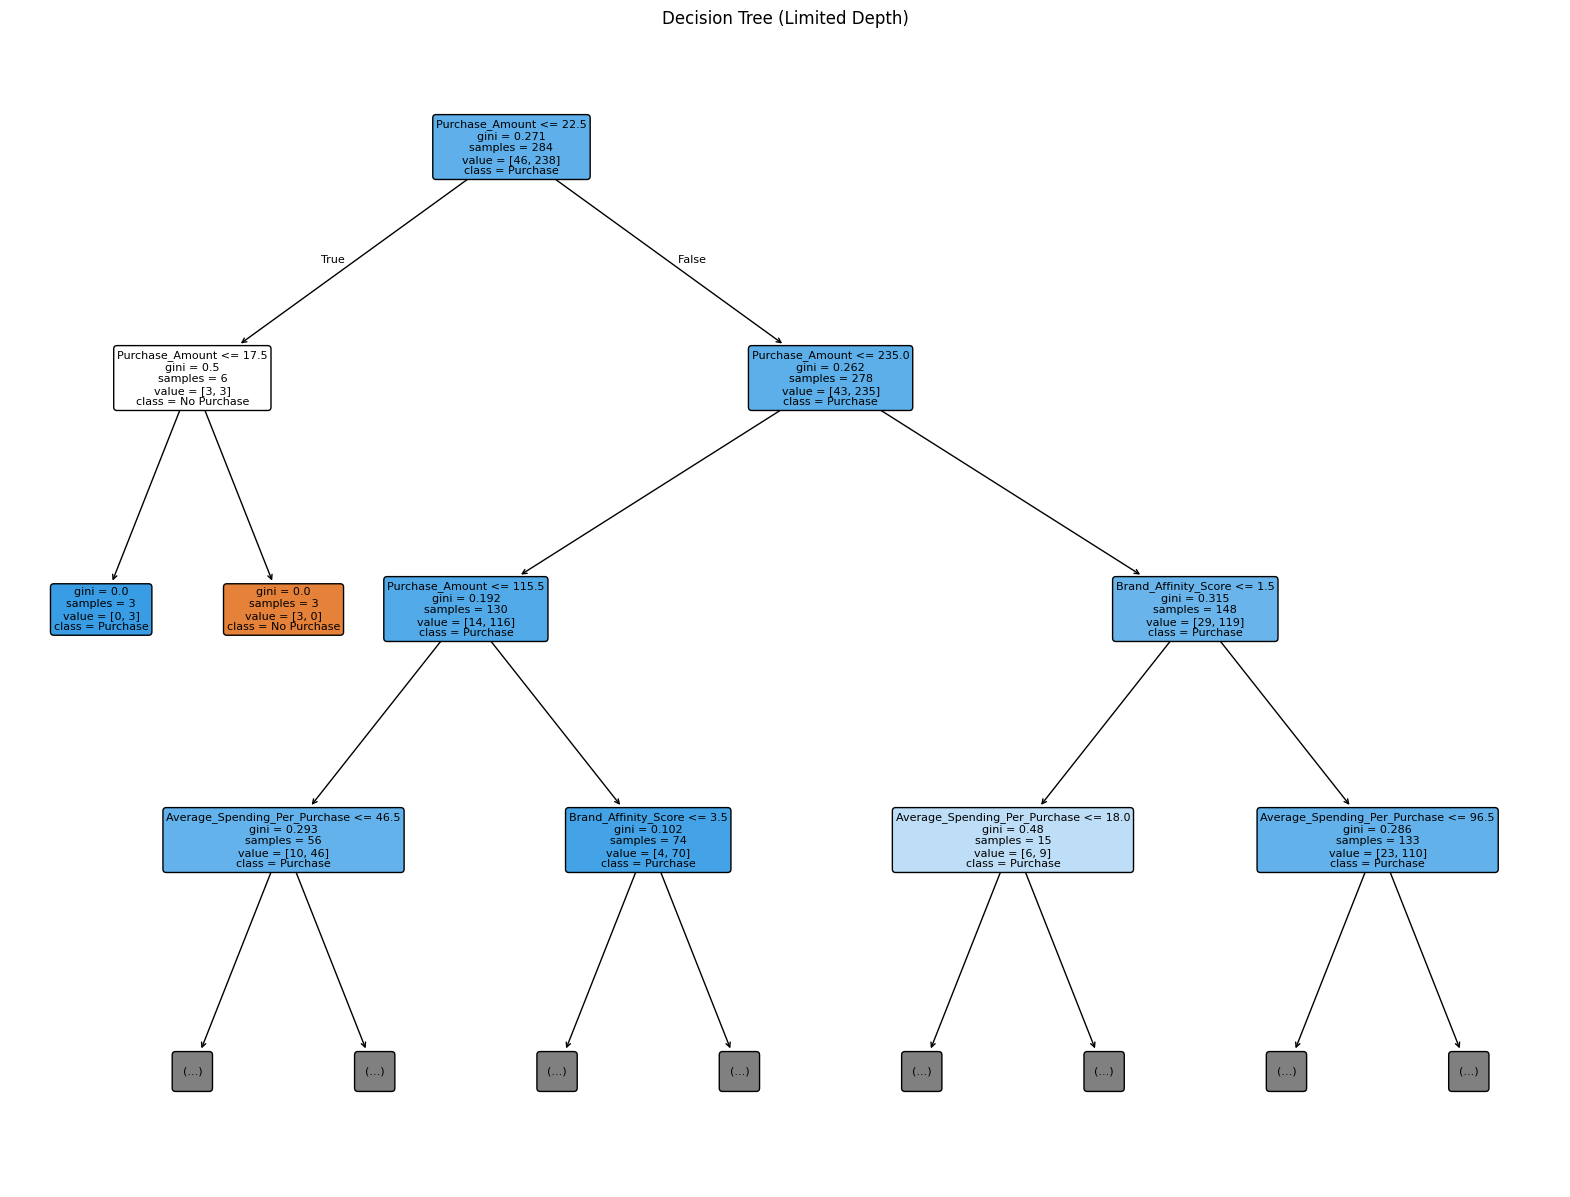

In [100]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Limit the depth of the tree for visualization purposes
plt.figure(figsize=(20, 15))  # Adjust size to make it manageable
plot_tree(
    dt_classifier,
    feature_names=features,
    class_names=["No Purchase", "Purchase"],
    filled=True,
    rounded=True,
    max_depth=3,  # Limit depth to 3 levels
    fontsize=8
)
plt.title("Decision Tree (Limited Depth)")
plt.show()


In [102]:
feature_importances = dt_classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the feature importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance Table:")
print(feature_importance_df)


Feature Importance Table:
                         Feature  Importance
2                Purchase_Amount    0.505265
0  Average_Spending_Per_Purchase    0.373231
1           Brand_Affinity_Score    0.121505


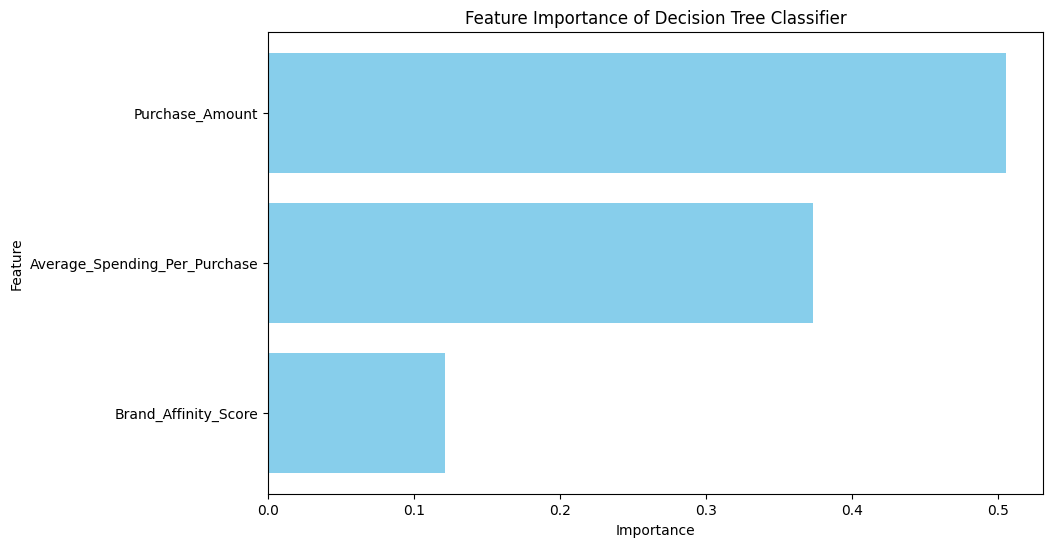

In [104]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Bar chart for Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Decision Tree Classifier')
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.show()

**Module 4: Clustering Analysis:**

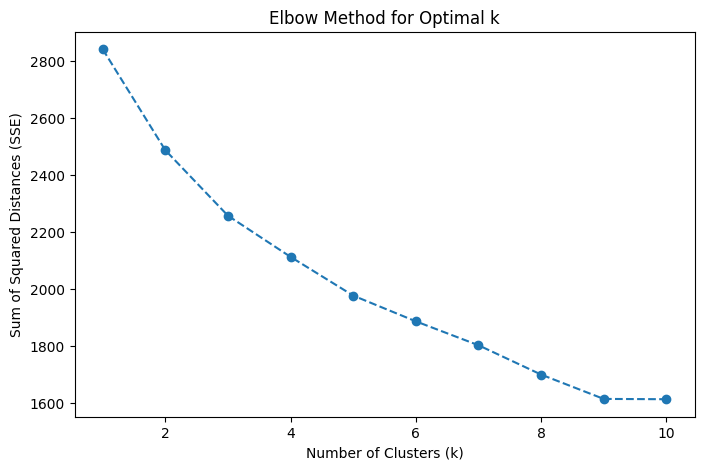

In [ ]:
# Step 1: Drop irrelevant columns
df_clustering = df.drop(columns=["Customer_ID", "Transaction_ID", "Address", "Will_Purchase_Next_Month"], errors="ignore")

# Step 2: Encode categorical columns
categorical_columns = ["Gender", "Income_Level"]
label_encoders = {}
for col in categorical_columns:
    if col in df_clustering.columns:
        encoder = LabelEncoder()
        df_clustering[col] = encoder.fit_transform(df_clustering[col])
        label_encoders[col] = encoder

# Step 3: Drop datetime columns or convert them if necessary
datetime_columns = ["Purchase_Date", "Month", "Year"]
df_clustering = df_clustering.drop(columns=datetime_columns, errors="ignore")

# Step 4: Select numeric columns only
df_clustering = df_clustering.select_dtypes(include=["number"])

# Step 5: Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_clustering)

# Step 6: Determine the optimal number of clusters (k) using the Elbow method
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)

# Step 7: Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Distances (SSE)")
plt.title("Elbow Method for Optimal k")
plt.show()



Cluster Analysis (Mean Values):
               Age  Income_Level  Product_Category  Purchase_Amount  \
Cluster                                                               
0        40.666667      1.253968               0.0       235.190476   
1        48.983333      1.233333               0.0       247.133333   
2        56.195266      0.923077               0.0       244.698225   

         Average_Spending_Per_Purchase  Purchase_Frequency_Per_Month  \
Cluster                                                                
0                            41.095238                      5.976190   
1                            46.816667                      1.933333   
2                            53.893491                      6.005917   

         Brand_Affinity_Score     Month         Year  \
Cluster                                                
0                    4.722222  6.722222  2002.984127   
1                    4.883333  7.100000  1997.533333   
2                    5.698

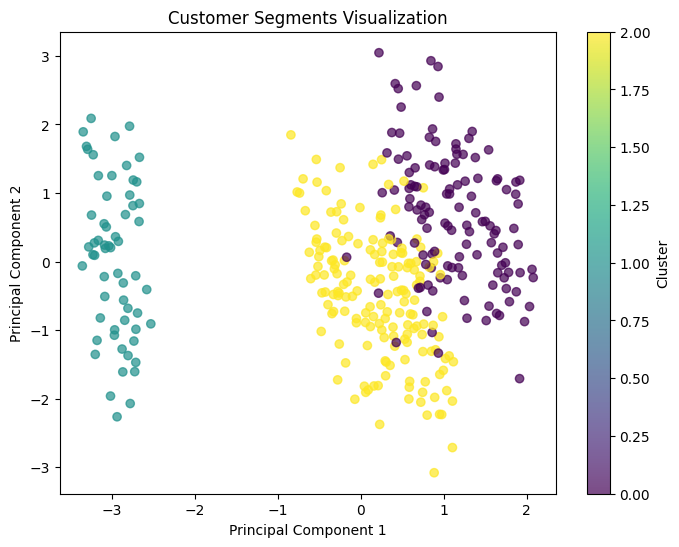

Silhouette Score: 0.14072429237712897


In [ ]:

# Step 1: Ensure only numeric columns are used for clustering
numeric_columns = df.select_dtypes(include=["number"]).columns
df_clustering = df[numeric_columns]

# Step 2: Scale the data for K-Means
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# Step 3: Apply K-Means Clustering (already specified k value, no elbow)
k = 3  # Set the number of clusters (you can change this if needed)
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# Step 4: Add cluster labels to the original dataset
df["Cluster"] = clusters

# Step 5: Analyze cluster characteristics (mean values for numeric features)
cluster_analysis = df.groupby("Cluster")[numeric_columns].mean()
print("\nCluster Analysis (Mean Values):")
print(cluster_analysis)

# Step 6: Visualize clusters using PCA (for 2D visualization)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=df["Cluster"], cmap='viridis', alpha=0.7)
plt.title("Customer Segments Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Step 7: Validate clustering with Silhouette Score (to check cluster separation)
sil_score = silhouette_score(df_scaled, clusters)
print(f"Silhouette Score: {sil_score}")

# Optional: Save the clustered dataset
df.to_csv("clustered_customers.csv", index=False)



Cluster Characteristics (Mean Values):
         Purchase_Amount  Average_Spending_Per_Purchase  \
Cluster                                                   
0             242.153846                      44.123077   
1             239.442424                      51.818182   
2             247.133333                      46.816667   

         Purchase_Frequency_Per_Month  Brand_Affinity_Score  Income_Level  \
Cluster                                                                     
0                            5.838462              4.584615      1.215385   
1                            6.115152              5.830303      0.945455   
2                            1.933333              4.883333      1.233333   

         Gender  
Cluster          
0        Female  
1         Other  
2         Other  


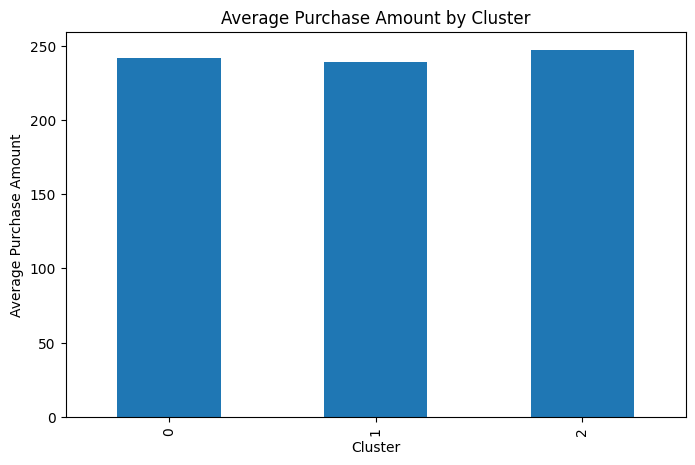

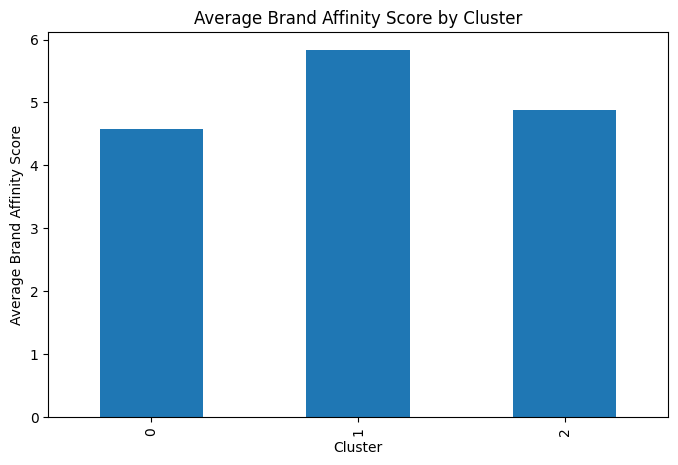

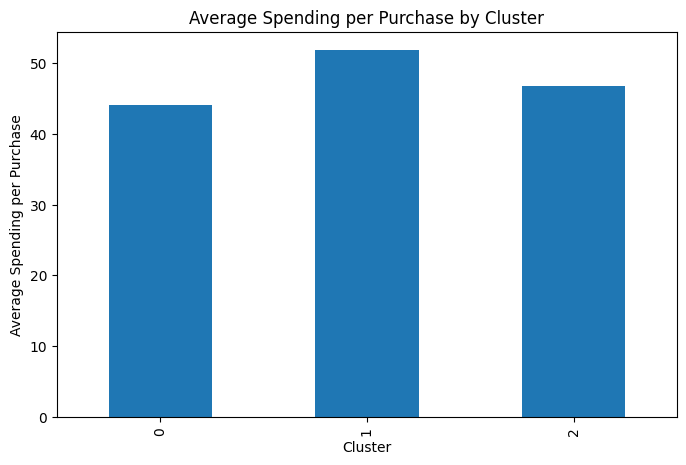

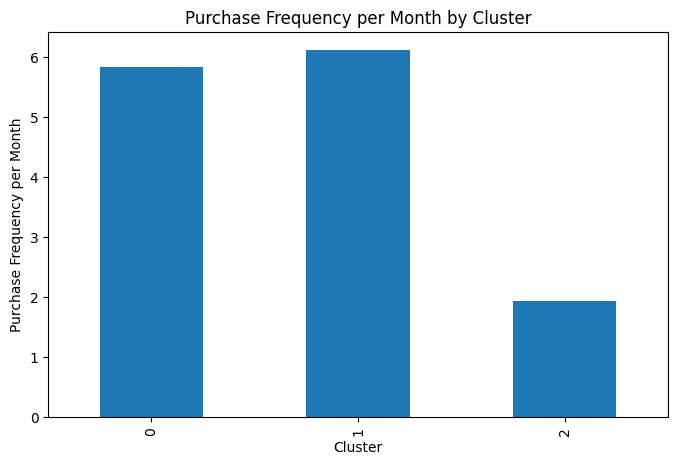


Significant Differences Between Clusters:
Cluster with highest average purchase amount: Cluster 2
Cluster with highest brand affinity score: Cluster 1
Cluster with highest average income level: Cluster 2

High Spending Customers:
         Purchase_Amount  Average_Spending_Per_Purchase  \
Cluster                                                   
2             247.133333                      46.816667   

         Purchase_Frequency_Per_Month  Brand_Affinity_Score  Income_Level  \
Cluster                                                                     
2                            1.933333              4.883333      1.233333   

        Gender  
Cluster         
2        Other  

Low Spending Customers:
         Purchase_Amount  Average_Spending_Per_Purchase  \
Cluster                                                   
0             242.153846                      44.123077   
1             239.442424                      51.818182   

         Purchase_Frequency_Per_Month  Brand_A

In [ ]:
cluster_analysis = df.groupby("Cluster").agg({
    'Purchase_Amount': 'mean',
    'Average_Spending_Per_Purchase': 'mean',
    'Purchase_Frequency_Per_Month': 'mean',
    'Brand_Affinity_Score': 'mean',
    'Income_Level': 'mean',  # assuming numeric encoding of income levels
    'Gender': lambda x: x.mode()[0],  # Most common gender per cluster
    # Add more features as necessary
})

# Step 2: Display cluster characteristics
print("\nCluster Characteristics (Mean Values):")
print(cluster_analysis)

# Optional: Visualize the differences between clusters using bar plots
# Plotting average Purchase Amount per cluster
plt.figure(figsize=(8, 5))
cluster_analysis['Purchase_Amount'].plot(kind='bar')
plt.title('Average Purchase Amount by Cluster')
plt.ylabel('Average Purchase Amount')
plt.xlabel('Cluster')
plt.show()

# Plotting Brand Affinity Score per cluster
plt.figure(figsize=(8, 5))
cluster_analysis['Brand_Affinity_Score'].plot(kind='bar')
plt.title('Average Brand Affinity Score by Cluster')
plt.ylabel('Average Brand Affinity Score')
plt.xlabel('Cluster')
plt.show()

# Optional: More visualizations for other key features
# Plotting Average Spending per Purchase per cluster
plt.figure(figsize=(8, 5))
cluster_analysis['Average_Spending_Per_Purchase'].plot(kind='bar')
plt.title('Average Spending per Purchase by Cluster')
plt.ylabel('Average Spending per Purchase')
plt.xlabel('Cluster')
plt.show()

# Plotting Purchase Frequency per Month per cluster
plt.figure(figsize=(8, 5))
cluster_analysis['Purchase_Frequency_Per_Month'].plot(kind='bar')
plt.title('Purchase Frequency per Month by Cluster')
plt.ylabel('Purchase Frequency per Month')
plt.xlabel('Cluster')
plt.show()

# Step 3: Identify Significant Differences
# Example insights based on cluster mean values
print("\nSignificant Differences Between Clusters:")

# Which cluster has the highest average purchase amount?
highest_purchase_amount_cluster = cluster_analysis['Purchase_Amount'].idxmax()
print(f"Cluster with highest average purchase amount: Cluster {highest_purchase_amount_cluster}")

# Which cluster has the highest brand affinity score?
highest_brand_affinity_cluster = cluster_analysis['Brand_Affinity_Score'].idxmax()
print(f"Cluster with highest brand affinity score: Cluster {highest_brand_affinity_cluster}")

# Patterns between income level and cluster
highest_income_cluster = cluster_analysis['Income_Level'].idxmax()
print(f"Cluster with highest average income level: Cluster {highest_income_cluster}")

# Step 4: Behavioral Insights - Segmenting customers
# High-spending, brand-loyal customers vs. price-sensitive, low-frequency buyers
high_spending_customers = cluster_analysis[cluster_analysis['Purchase_Amount'] > cluster_analysis['Purchase_Amount'].median()]
low_spending_customers = cluster_analysis[cluster_analysis['Purchase_Amount'] <= cluster_analysis['Purchase_Amount'].median()]

print("\nHigh Spending Customers:")
print(high_spending_customers)

print("\nLow Spending Customers:")
print(low_spending_customers)

# Optional: Save the clustered dataset for future analysis
df.to_csv("clustered_customers.csv", index=False)


**Module 5 in pdf**